In [380]:
%pip install razdel
%pip install pymystem3
%pip install natasha

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [488]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 293 kB 1.7 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


# Подгрузка библиотек и датасета

In [489]:
import pandas as pd
from razdel import tokenize, sentenize
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

In [306]:
data = pd.read_csv("/home/jupyter/mnt/s3/newbacketttt/train.csv")

In [307]:
data = data.rename(columns={"Unnamed: 0": "ID"})

# Проверка датасета

In [381]:
data.head(5)

,ID,sentence,1category,2category,sentiment,sent_len
0,4754,При этом всегда получал качественные услуги.,Communication,None,+,44
1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,None,−,49
2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,None,−,44
3,11640,Отвратительное отношение к клиентам.,Communication,None,−,36
4,5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,None,+,56


In [479]:
df_test = pd.read_csv("/home/jupyter/mnt/s3/newbacketttt/test_for_participants.csv")

## Интересно что уникальных предложений меньше чем ID

In [382]:
data.nunique()

ID           19361
sentence      7166
1category        5
2category        4
sentiment        3
sent_len       420
dtype: int64

In [117]:
data.isna().sum()

ID               0
sentence         0
1category        0
2category    18362
sentiment        0
sent_len         0
dtype: int64

In [309]:
data["sent_len"] = data['sentence'].apply(len)

In [310]:
print(f'Min len(sentence):{min(data["sent_len"])}')
print(f'Max len(sentence):{max(data["sent_len"])}')

Min len(sentence):31
Max len(sentence):1155


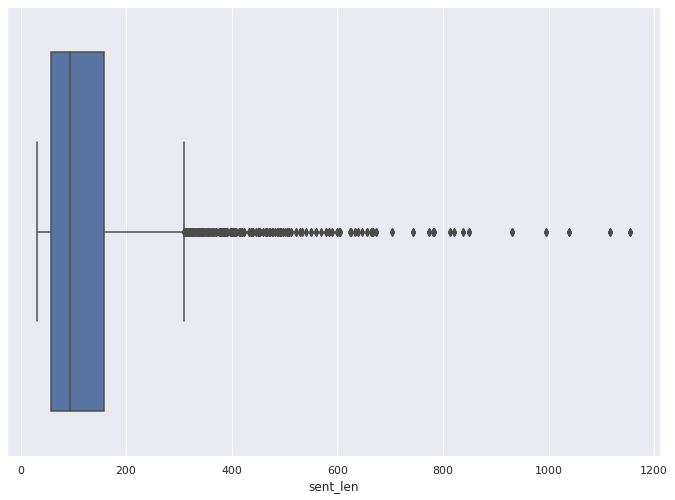

In [493]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x=data["sent_len"])

In [500]:
q75,q25 = np.percentile(data["sent_len"],[75,25])
intr_qr = q75-q25
q_max = q75+(1.5*intr_qr)
q_min = q25-(1.5*intr_qr)

In [549]:
q_min

-94.5

## Посмотрим на то различаются ли признаки для одинаковых предложений

In [383]:
sent_3 = [] # переменная для тех предложений в которых все оценки разные
sent_2 = [] # для тех предложений в которых 2 оценки разнятся
sent_big = []
what = []
for sntnc in data.sentence.unique():
    if data[data["sentence"] == sntnc]["sentiment"].nunique() == 3:
        sent_3.append(sntnc)
    elif len(data[data["sentence"] == sntnc]["sentiment"]) > 3:
        sent_big.append(sntnc)
    elif (data[data["sentence"] == sntnc]["sentiment"].nunique() == 2):
        join_sent = np.array(data[data["sentence"] == sntnc]["sentiment"])
        sent_2.append((sntnc, join_sent))
    elif data[data["sentence"] == sntnc]["sentiment"].nunique() != 1: what.append(sntnc)

In [384]:
print(f'Уникальных предложений в которых разняться все оценки (cat1): {len(sent_3)}')
print(f'Уникальных предложений в которых разняться 2 оценки (cat2): {len(sent_2)}')
print(f'Уникальных предложений оценок к которым больше чем 3: {len(sent_big)}')

Уникальных предложений в которых разняться все оценки (cat1): 34
Уникальных предложений в которых разняться 2 оценки (cat2): 1142
Уникальных предложений оценок к которым больше чем 3: 2


# Очистка датасета от лишних значений

In [467]:
data_cat3 = data[~data["sentence"].isin(sent_3)].copy() # Избавимся от предложений где разняться все оценки

In [468]:
def transform_to_digits(x):
    if x == '+': return 11
    elif x == '−': return 3
    else: return 1000

In [469]:
data_cat3['sentiment_count'] = data_cat3['sentiment'].apply(transform_to_digits) 

In [470]:
tmp_df = data_cat3[['sentence','sentiment_count']].groupby(['sentence'], as_index=False).sum()

In [510]:
tmp_df['sentence'][tmp_df['sentiment_count']==17].iloc[0]

'"Наконец-то куда надо, подумал я" и почти без раздражения рассказал свою историю в девятый раз. Мне объяснили, что мой личный сотовый номер был указан в качестве рабочего номера телефона при заполнении анкеты человеком.'

In [544]:
data[data['sentence'] == sent_3[0]]

,ID,sentence,1category,2category,sentiment,sent_len
51,15794,МКБ среагировал очень чётко (всё правильно!,Quality,None,−,43
11356,1186,МКБ среагировал очень чётко (всё правильно!,?,None,?,43
18787,336,МКБ среагировал очень чётко (всё правильно!,?,None,+,43


In [542]:
data_cat3[data_cat3['sentence'] == sent_3[0]].drop(['1category', '2category', 'sent_len'], axis=1)

,ID,sentence,sentiment,sentiment_count


In [548]:
data_cat3[data_cat3['sentence'] == tmp_df['sentence'][tmp_df['sentiment_count']==25].iloc[0]].drop(['1category', '2category', 'sent_len'], axis=1)

,ID,sentence,sentiment,sentiment_count
247,10465,"Больше всего меня удивило, что она не раздража...",−,3
11872,5922,"Больше всего меня удивило, что она не раздража...",+,11
12237,6428,"Больше всего меня удивило, что она не раздража...",+,11


In [471]:
print(f'Всего {len(tmp_df["sentiment_count"].unique())} уникальных комбинаций')

Всего 20 уникальных комбинаций


In [472]:
dict_unique_sc = {33: 1, 2011: 1, 1022: 1, 22: 1, 1011: 1, 11: 1, 4022: 1,
                  2003: 1, 1006: -1, 9: -1, 6: -1, 3: -1, 1003: -1, 18: -1,
                  3000: 0, 2000: 0, 1000: 0,
                  17: 'ND', 14: 'ND', 25: 'ND'}

In [473]:
def transf_to_norm_digits(x):
    return dict_unique_sc[x]

In [474]:
tmp_df['sentiment'] = tmp_df['sentiment_count'].apply(transf_to_norm_digits) 

In [526]:
tmp_df

,sentence,sentiment_count,sentiment
0,10.12.2020 20:57 Хотелось бы выразить огромну...,33,1
1,"!, на что сотрудник банка ответила мне что дан...",1006,-1
2,"!, тем самым оставив меня без средств к сущест...",9,-1
3,!16 ноября сего года я обращаюсь к администрат...,2003,1
4,!22.02.2020 заблокировали счет якобы из-за про...,9,-1
...,...,...,...
7127,я своевременно и в полном объеме исполнял ВСЕ ...,2000,0
7128,я у сотрудника спросила- получила ответ. но со...,9,-1
7129,"– восхищаюсь я. Проходит еще неделя... Ну, я д...",3000,0
7130,"…Вы своих клиентов совсем не уважаете, считая ...",9,-1


In [546]:
tmp_df[~(tmp_df['sentiment'] == 'ND')]

,sentence,sentiment_count,sentiment
0,10.12.2020 20:57 Хотелось бы выразить огромну...,33,1
1,"!, на что сотрудник банка ответила мне что дан...",1006,-1
2,"!, тем самым оставив меня без средств к сущест...",9,-1
3,!16 ноября сего года я обращаюсь к администрат...,2003,1
4,!22.02.2020 заблокировали счет якобы из-за про...,9,-1
...,...,...,...
7127,я своевременно и в полном объеме исполнял ВСЕ ...,2000,0
7128,я у сотрудника спросила- получила ответ. но со...,9,-1
7129,"– восхищаюсь я. Проходит еще неделя... Ну, я д...",3000,0
7130,"…Вы своих клиентов совсем не уважаете, считая ...",9,-1


In [528]:
new_df = tmp_df[~(tmp_df['sentiment'] == 'ND')].copy()

In [529]:
new_df = new_df.drop(['sentiment_count'], axis=1)

## Чистый датасет

In [377]:
new_df.head(5)

,sentence,sentiment
0,10.12.2020 20:57 Хотелось бы выразить огромну...,1
1,"!, на что сотрудник банка ответила мне что дан...",-1
2,"!, тем самым оставив меня без средств к сущест...",-1
3,!16 ноября сего года я обращаюсь к администрат...,1
4,!22.02.2020 заблокировали счет якобы из-за про...,-1


In [478]:
new_df.to_csv('/home/jupyter/mnt/s3/newbacketttt/train_clean.csv')

In [525]:
new_df.nunique()

sentence     7019
sentiment       3
dtype: int64

# Токенизация

In [397]:
import string
import pandas as pd
import torch
import natasha
from razdel import tokenize, sentenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from string import digits
from pymystem3 import Mystem
mystem = Mystem()
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Failed to deserialize variable 'mystem'. Run the following code to delete it:
  del_datasphere_variables('mystem')
Traceback (most recent call last):
  File "/kernel/lib/python3.8/site-packages/ml_kernel/state/state_protocol.py", line 283, in _load_component
    value = unpickler.load()
  File "/kernel/lib/python3.8/site-packages/ipystate/impl/dispatch/common.py", line 141, in _create_file
    f = open(name, mode, encoding=encoding)
OSError: [Errno 9] Bad file descriptor

The above exception was the direct cause of the following exception:

ml_kernel.state.state_protocol.KernelStateProtocol.DeserializationException: ['mystem']


In [399]:
ds = new_df

In [400]:
ds.head(5)

,sentence,sentiment
0,10.12.2020 20:57 Хотелось бы выразить огромну...,1
1,"!, на что сотрудник банка ответила мне что дан...",-1
2,"!, тем самым оставив меня без средств к сущест...",-1
3,!16 ноября сего года я обращаюсь к администрат...,1
4,!22.02.2020 заблокировали счет якобы из-за про...,-1


In [426]:
ds

,sentence,sentiment
0,10.12.2020 20:57 Хотелось бы выразить огромну...,1
1,"!, на что сотрудник банка ответила мне что дан...",-1
2,"!, тем самым оставив меня без средств к сущест...",-1
3,!16 ноября сего года я обращаюсь к администрат...,1
4,!22.02.2020 заблокировали счет якобы из-за про...,-1
...,...,...
7127,я своевременно и в полном объеме исполнял ВСЕ ...,0
7128,я у сотрудника спросила- получила ответ. но со...,-1
7129,"– восхищаюсь я. Проходит еще неделя... Ну, я д...",0
7130,"…Вы своих клиентов совсем не уважаете, считая ...",-1


In [401]:
trg_sent = ds['sentiment']

trg_cat_dum = pd.get_dummies(trg_sent)

Exception ignored in: <function Mystem.__del__ at 0x7f1702f69c10>
Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.8/site-packages/pymystem3/mystem.py", line 196, in __del__
    self.close()  # terminate process on exit
  File "/home/jupyter/.local/lib/python3.8/site-packages/pymystem3/mystem.py", line 216, in close
    if self._proc is not None:
AttributeError: 'Mystem' object has no attribute '_proc'


In [446]:
df = ds['sentence'].copy()

In [445]:
def delete_punc(df):
    for i in range(df.shape[0]):
        text = df.iloc[i]
        text_new = text.translate (str.maketrans('', '', string.punctuation))
        df.iloc[i] = text_new
    return df

def del_stopwords(df):
    for i in range(df.shape[0]):
        text = df.iloc[i]
        text = text.split()
        text_filtered = " ".join([word for word in text if word not in stopwords.words('russian')])
        df.iloc[i] = text_filtered.lower()
    return df

def del_digits(df):
    for i in range(df.shape[0]):
        text = df.iloc[i].split()
        text_filtered = [word for word in text if word not in digits]
        text_filtered = " ".join([re.sub('[0-9]', '', i) for i in text_filtered])
        df.iloc[i] = text_filtered
    return df

def lemmatizing(df):
    mystem = Mystem()
    for i in range(df.shape[0]):
        text = df.iloc[i]
        text_lemm = mystem.lemmatize(text)
        text_lemm = "".join(text_lemm)
#         text = text.split()
#         text_stem = ' '.join(list(map(lambda x: lemmatizer.lemmatize(x), text)))
        text_lemm = text_lemm.replace('\n',"")
        df.iloc[i] = text_lemm
    return df

def tokenization(df):
    for i in range(df.shape[0]):
        text = str(df.iloc[i])
        tokens = list(tokenize(text))
        text_tokenized = [_.text for _ in tokens]
        df.iloc[i] = text_tokenized
    return df

def form_dict(df):
    dictionary = dict()
    j = 1
    for i in range(df.shape[0]):
        text = df.iloc[i]
        for word in text:
            if (word in dictionary) == False:
                dictionary[word] = j
                j+=1
    return dictionary

In [447]:
df_no_punc = delete_punc(df).copy()
df_filtered = del_stopwords(df_no_punc).copy()
df_no_dig = del_digits(df_filtered).copy() 
df_lemmatized = lemmatizing(df_no_dig).copy()
df_tokenized = tokenization(df_lemmatized).copy()

In [457]:
df_lemmatized = df_lemmatized.apply(lambda x: " ".join(x))

In [458]:
pd.concat((df_lemmatized, trg_sent), axis=1).to_csv("/home/jupyter/mnt/s3/newbacketttt/data_lemmatised.csv")

# Категории

In [460]:
cat_3 = [] # переменная для тех предложений в которых все оценки разные
cat_2 = [] # для тех предложений в которых 2 оценки разнятся
cat_big = []
what = []
for sntnc in data['sentence'].unique():
    if data[data["1category"] == sntnc]["1category"].nunique() == 3:
        cat_3.append(sntnc)
    elif len(data[data["1category"] == sntnc]["1category"]) > 3:
        cat_big.append(sntnc)
    elif (data[data["1category"] == sntnc]["1category"].nunique() == 2):
        join_cat = np.array(data[data["1category"] == cat]["1category"])
        cat_2.append((sntnc, join_cat))
    elif data[data["1category"] == cat]["1category"].nunique() != 1: what.append(cat)

In [531]:
df_new_test = pd.read_csv('/home/jupyter/mnt/s3/newbacketttt/1sentencenewtest.csv')